<a href="https://colab.research.google.com/github/andrewsiyoon/spiking-seRNN/blob/main/snnLeaky_learnable_betas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 2.7 MB/s 


In [19]:
# Imports ---------------
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import surrogate

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

In [20]:
# Download input dataset -----

# Dataloader arguments ---------------
batch_size = 128
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define a transformation ---------------
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders ---------------
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [37]:
# Define Network -----

#This module defines the spiking network with learnable membrane time constants (modeling neural heterogeneity). 
#The time constant is clipped at [0,1) as the Goodman paper does. 
#Also possible to initialize all neurons in a single layer to the same value with beta1 = int, but chose to do torch.rand for individualization
#Running this cell will print the initialized betas as a tensor (can check that they change each time, and that the number corresponds to the unit #).

#Network Architecture
num_inputs = 28*28 #We transformed the MNIST dataset to dimensions (28,28) in above code
num_hidden = 1000
num_outputs = 10

#Temporal Dynamics
num_steps = 25

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Independent decay rate initialization for each neuron in Layer 1
        beta1 = torch.rand((num_hidden), dtype = torch.float)
        print(beta1)
        # Independent decay rate initialization for each  neuron in Layer 2: [0, 1)
        beta2 = torch.rand((num_outputs), dtype = torch.float) #.to(device) #.to(device) is for transfer to CUDA
        print(beta2)
        spike_grad = surrogate.fast_sigmoid()      

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden) #Applies linear transformation to input data.
        self.lif1 = snn.Leaky(beta=beta1, spike_grad=spike_grad, learn_beta=True) #First spiking neuron layer: integrates weighted input over time and emits a spike if threshold is met
        #learn_beta = True allows for decay rate learning for each neuron.
        self.fc2 = nn.Linear(num_hidden, num_outputs) #Applies a linear transformation to the output spikes of fc1
        self.lif2 = snn.Leaky(beta=beta2, spike_grad=spike_grad, learn_beta=True) #Second spiking neuron layer: integrates weighted spikes over time

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
#Load the network onto CUDA if available
net = Net().to(device)

#Prints
print(net)
params = list(net.parameters())
print(len(params))
print(params[0].size())

tensor([7.6241e-01, 6.1414e-01, 3.5216e-01, 8.9803e-01, 5.0272e-01, 5.3483e-01,
        8.4460e-01, 3.9458e-01, 9.6405e-01, 1.4380e-01, 4.8869e-01, 9.0424e-01,
        7.9430e-01, 9.7842e-01, 1.7999e-01, 4.5041e-01, 5.5121e-01, 4.2654e-01,
        5.9359e-01, 1.8412e-01, 7.6740e-02, 9.9353e-01, 7.5352e-01, 6.6025e-01,
        4.8827e-01, 8.6483e-01, 6.7654e-02, 5.8547e-01, 7.6613e-02, 2.9803e-01,
        5.8609e-01, 5.7435e-01, 2.8914e-01, 9.0698e-01, 2.2718e-01, 2.0105e-04,
        8.6524e-01, 1.5793e-01, 6.9057e-01, 6.6392e-01, 5.6109e-02, 3.7316e-01,
        1.9462e-01, 4.7304e-01, 9.3560e-01, 9.2902e-01, 1.0756e-01, 6.7148e-01,
        7.9474e-01, 6.8087e-01, 8.8299e-01, 1.9346e-01, 9.7079e-01, 2.4151e-01,
        7.3645e-01, 7.1563e-01, 7.0415e-01, 2.6730e-02, 9.4124e-01, 1.5441e-01,
        6.3005e-01, 8.8334e-01, 5.7343e-01, 4.8533e-01, 9.3732e-02, 5.0582e-01,
        7.2559e-01, 7.5845e-01, 7.8111e-01, 2.0353e-01, 1.2353e-01, 9.9483e-01,
        8.8711e-01, 9.3309e-01, 4.7304e-

In [22]:
# Accuracy calculator and print function ---------------
# The first function calculates the batch accuracy, by passing data into the network and summating the spikes per neuron.
# Then, it compares the highest sum (index) with the actual target to calculate accuracy.
# The second function will be called later to report the epoch/iteration #, train set loss, test set loss, and accuracy measures.

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [23]:
# Loss function ---------------

loss = nn.CrossEntropyLoss() 

#Single PyTorch function that takes the softmax of the output layer and generates a loss at the output 
#(see Pytorch documentation for possible parameters)

In [24]:
# Adam optimizer ---------------

optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

#Can adjust the learning rate (lr), and the betas as well?

In [25]:
# Training paradigm ---------------

num_epochs = 1 #Modify if you want to train for >1 epoch
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch: #taking a batch of data and loading it into CUDA
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1)) #flatten the input data into a vector and pass it into the network
        #Batch_size was defined earlier as 784, then transformed into a 28*28
        #The input is taken across 25 time steps, 128 data samples, and 10 output neurons which you can see through print(mem_rec.size())

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device) #Initialize the total loss value
        for step in range(num_steps): #Sum loss at every step
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad() #Clear previously stored gradients
        loss_val.backward() #Calculate the gradients
        optimizer.step() #Weight update

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
                print(beta)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 57.41
Test Set Loss: 55.73
Train set accuracy for a single minibatch: 14.84%
Test set accuracy for a single minibatch: 9.38%


0.95
Epoch 0, Iteration 50
Train Set Loss: 13.96
Test Set Loss: 15.78
Train set accuracy for a single minibatch: 89.06%
Test set accuracy for a single minibatch: 80.47%


0.95
Epoch 0, Iteration 100
Train Set Loss: 17.23
Test Set Loss: 10.06
Train set accuracy for a single minibatch: 83.59%
Test set accuracy for a single minibatch: 90.62%


0.95
Epoch 0, Iteration 150
Train Set Loss: 8.73
Test Set Loss: 9.14
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 90.62%


0.95


KeyboardInterrupt: ignored

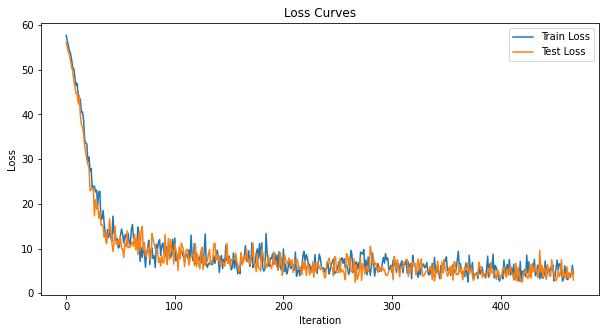

In [9]:
# Plot Loss ---------------

fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

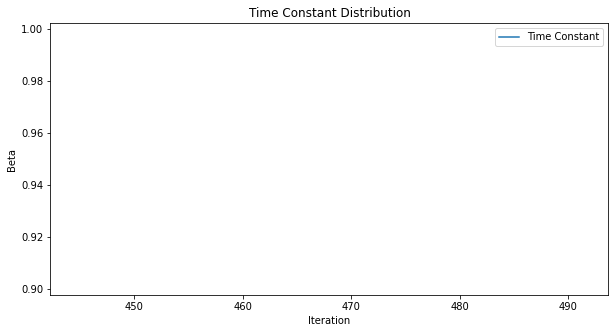

In [16]:
# Plot Membrane Time Constants ----------

#Currently not working. Need to figure out how to get the iterations to go from 1 - 500, they automatically default to 450 - 490 for some reason.

fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(counter, beta)
plt.title("Time Constant Distribution")
plt.legend(["Time Constant"])
plt.xlabel("Iteration")
plt.ylabel("Beta")
plt.show()

In [ ]:
# Calculate accuracy ---------------

total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")